In [59]:
# Real life data

%load_ext autoreload
import logging
import threading
import itertools
import warnings
import pandas as pd  
import numpy as np  
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, GeneralizedAnomalyScore)
from mmfunctions.telemanom import (TelemanomConfig, TelemanomModel, TelemanomEstimator, LSTMRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
from scipy.stats import wasserstein_distance, energy_distance, gaussian_kde
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

EngineLogging.configure_console_logging(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load and unroll the data first

In [2]:
# from https://stackoverflow.com/questions/43297853/modifying-timestamps-in-pandas-to-make-index-unique/43298598
def deal_with_duplicate_ts(df):
    # get duplicated values as float and replace 0 with NaN
    values = df.index.duplicated(keep=False).astype(float)
    values[values==0] = np.NaN

    missings = np.isnan(values)
    cumsum = np.cumsum(~missings)
    diff = np.diff(np.concatenate(([0.], cumsum[missings])))
    values[missings] = -diff

    # print result
    df.index = df.index + np.cumsum(values).astype(np.timedelta64)
    return df

In [3]:
df_input_raw = pd.read_csv('./Cakebread36_datalastweek.csv', index_col=False, parse_dates=['timestamp'])
df_input_raw['temperature'] = df_input_raw['floatvalue']

df_input = df_input_raw[['deviceid','timestamp','temperature']]

df_input = df_input.set_index(['timestamp'])
df_input = deal_with_duplicate_ts(df_input)

df_input = df_input.reset_index().set_index(['deviceid','timestamp'])

temperature = df_input['temperature'].values.reshape(-1,1)

temperature_scale = RobustScaler().fit(temperature).transform(temperature)

df_input['temperature'] = temperature_scale
df_input['histogram'] = 0
df_input['iforest'] = 0
df_input['kmeans'] = 0

df_input = df_input.ewm(com=0.5).mean()

#temperature.shape
df_input.shape

(396, 4)

In [4]:
hbos = HBOS(n_bins=15)
X = df_input['temperature'].values.reshape(-1,1)
hbos.fit(X)
df_input['histogram'] = hbos.predict_proba(X)
iforest = IForest(behaviour='new')
iforest.fit(X)
df_input['iforest'] = iforest.predict_proba(X)
kmeans = CBLOF()
kmeans.fit(X)
df_input['kmeans'] = kmeans.predict_proba(X)
#autoenc = AutoEncoder(hidden_neurons = [64, 32, 1, 1, 32, 64], verbose=0)
#autoenc.fit(X)
#auto = autoenc.predict_proba(X)
XX = np.hstack([X,X])
print (XX.shape)
vaenc = VAE(encoder_neurons=[32, 8, 2], decoder_neurons=[2,8,32], latent_dim=2, gamma=0.8, capacity=0.2, verbosity=0) 
vaenc.fit(XX)
vae = vaenc.predict_proba(XX)



/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


(396, 2)


/home/markus/.local/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  warnings.warn(


In [5]:
vae[:,0]

array([0.81562755, 0.9338189 , 0.827829  , 0.76060446, 0.89307462,
       0.89154401, 0.77243265, 0.88694021, 0.80103548, 0.73242255,
       0.85716841, 0.85522113, 0.74116111, 0.81148883, 0.81058165,
       0.71111819, 0.7168587 , 0.84371821, 0.82050612, 0.70896297,
       0.65756288, 0.81381454, 0.78651921, 0.68268144, 0.67277314,
       0.82410741, 0.72860885, 0.87278655, 0.81532702, 0.81210916,
       0.9842198 , 0.91083859, 0.9646493 , 0.95395457, 0.83513753,
       0.87927102, 0.93965374, 0.84967854, 0.84474587, 0.83317325,
       0.80509466, 0.81483615, 0.76868606, 0.85247342, 0.90592875,
       0.94255655, 0.9605288 , 0.9607759 , 0.97610529, 0.98601122,
       0.99918201, 0.99064632, 0.98676889, 0.95817178, 0.84830151,
       0.93229205, 0.9350848 , 0.84600519, 0.87655362, 0.83155178,
       0.77211561, 0.84040122, 0.75144656, 0.6814329 , 0.81185016,
       0.74095034, 0.72275082, 0.85019441, 0.69954331, 0.64441446,
       0.77470733, 0.70829511, 0.64071565, 0.7782555 , 0.80436

In [6]:
#df_input['autoenc'] = auto[:,0]
df_input['autoenc'] = vae[:,0]
#df_input['auto1'] = auto[:,1]
#auto.shape
vae.shape

df_input.head(2)

temperature  histogram   iforest  \
deviceid         timestamp                                               
CakebreadId_0036 2020-06-01 02:04:00    -0.896552   0.872259  0.863650   
                 2020-06-01 02:17:00    -0.353448   0.945976  0.966469   

                                        kmeans   autoenc  
deviceid         timestamp                                
CakebreadId_0036 2020-06-01 02:04:00  0.970537  0.815628  
                 2020-06-01 02:17:00  0.995634  0.933819

In [7]:
# setting to make life easier
Temperature='temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 1

df_i = df_input.copy()


In [11]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScore(Temperature, 12, spectral)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 12, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

gsi = GeneralizedAnomalyScore(Temperature, 12, gen)
et = gsi._build_entity_type(columns = [Column(Temperature,Float())])
gsi._entity_type = et
df_i = gsi.execute(df=df_i)

df_i.describe()

2020-06-14T17:35:16.922 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-14T17:35:16.924 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-14T17:35:16.957 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-14T17:35:16.958 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Saliency   Entity: CakebreadId_0036, result shape: (65,) score shape: (65,) input shape: (396,)
2020-06-14T17:35:17.007 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-14T17:35:17.007 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so

/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


,temperature,histogram,iforest,kmeans,autoenc,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore,TemperatureGeneralizedScore
count,396.000000,396.000000,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,-0.046129,0.842299,8.887724e-01,0.961288,0.866379,10.481943,82.698143,47.283263,0.620142,0.150756
std,0.793707,0.205668,1.344641e-01,0.073294,0.105577,28.262113,169.916332,86.229242,0.529238,0.284698
min,-1.799987,0.000000,1.110223e-16,0.000000,0.000000,0.008656,3.669044,3.434257,0.000000,0.011721
25%,-0.621676,0.818822,8.651824e-01,0.954620,0.814860,2.041975,10.027569,12.554894,0.421794,0.040993
50%,-0.061548,0.939650,9.319412e-01,0.968103,0.879625,4.726746,20.497584,18.490617,0.545676,0.061193
75%,0.500493,0.945976,9.623369e-01,0.984481,0.939552,10.310794,96.649586,52.736743,0.667437,0.167000
max,4.600477,1.000000,1.000000e+00,1.000000,0.999182,280.019841,1347.480336,638.025875,4.913877,2.084708


In [12]:
df_inputm2 = df_i.loc[['CakebreadId_0036']]
df_inputm2.reset_index(level=[0], inplace=True)
df_inputm2.describe()

,temperature,histogram,iforest,kmeans,autoenc,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore,TemperatureGeneralizedScore
count,396.000000,396.000000,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,-0.046129,0.842299,8.887724e-01,0.961288,0.866379,10.481943,82.698143,47.283263,0.620142,0.150756
std,0.793707,0.205668,1.344641e-01,0.073294,0.105577,28.262113,169.916332,86.229242,0.529238,0.284698
min,-1.799987,0.000000,1.110223e-16,0.000000,0.000000,0.008656,3.669044,3.434257,0.000000,0.011721
25%,-0.621676,0.818822,8.651824e-01,0.954620,0.814860,2.041975,10.027569,12.554894,0.421794,0.040993
50%,-0.061548,0.939650,9.319412e-01,0.968103,0.879625,4.726746,20.497584,18.490617,0.545676,0.061193
75%,0.500493,0.945976,9.623369e-01,0.984481,0.939552,10.310794,96.649586,52.736743,0.667437,0.167000
max,4.600477,1.000000,1.000000e+00,1.000000,0.999182,280.019841,1347.480336,638.025875,4.913877,2.084708


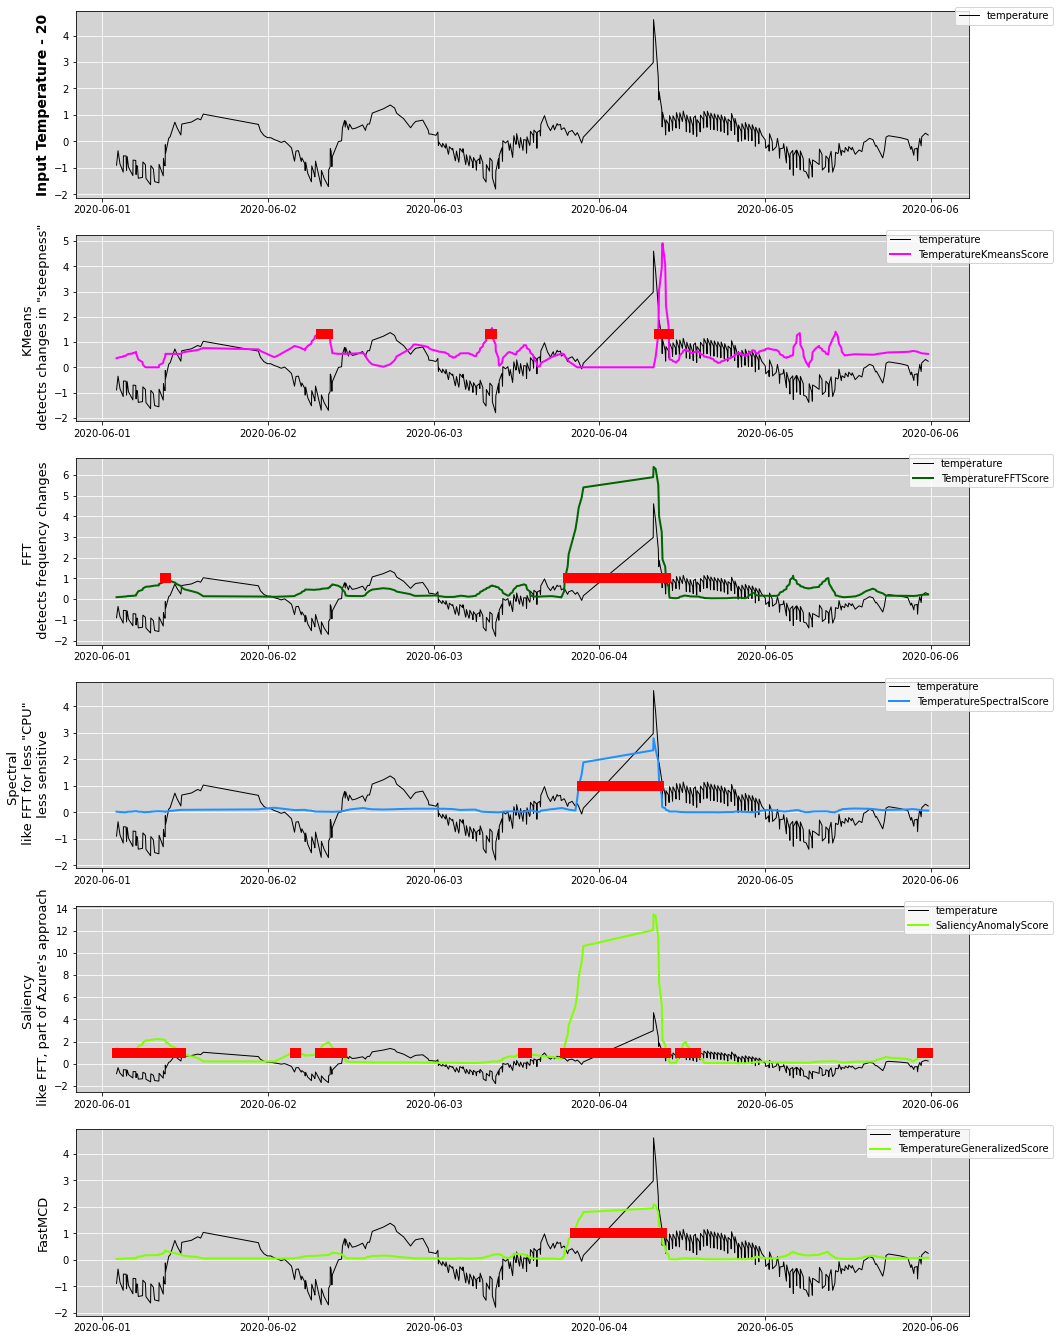

In [13]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break
df_inputm2[kmeansB] = df_inputm2[kmeans]
df_inputm2[kmeansB].values[df_inputm2[kmeansB] >= kmeans_break] = 4
df_inputm2[kmeansB].values[df_inputm2[kmeansB] < kmeans_break] = 3

# Scale spectral and saliency 
# df_inputm2[spectral].values[df_inputm2[spectral] >= spectral_break] = -spectral_break
# df_inputm2[sal].values[df_inputm2[sal] > sal_break] = sal_break



df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
df_inputm2[genA] = df_inputm2[gen]
df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Input)
#ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
#ax[cnt].plot(df_inputm2.index, -df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
#ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects changes in "steepness"',fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 3
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)
cnt = 4
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)
cnt = 5
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[gen]/gen_break, linewidth=2,color='chartreuse', label=gen)
ax[cnt].plot(df_inputm2.index, df_inputm2[genA]/gen_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FastMCD', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

In [14]:
%config InlineBackend.close_figures=False 
from ipywidgets import Layout, Button, ToggleButton, Box
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import Output



init_list = ['temperature','histogram', 'iforest', 'kmeans','autoenc']

items_layout = Layout( width='auto')

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    border='solid',
                    width='30%')

words = [ 'histogram', 'iforest', 'kmeans', 'autoenc']
items = [ToggleButton(description=word, layout=items_layout) for word in words]
box = Box(children=items, layout=box_layout)
ax = None

def plot_on_click(h,i, k, a):
    elements = ['temperature']
    if h:
        elements.append(words[0])
    if i:
        elements.append(words[1])
    if k:
        elements.append(words[2])
    if a:
        elements.append(words[3])
    # drop old figure first
    ax = plt.gca()
    if ax is not None:
        fig = ax.get_figure()
        fig.autofmt_xdate()
        plt.close(fig)
        
    df_subset = df_input[elements].reset_index().set_index('timestamp') #['2020-01-30 05':'2020-01-30 17']
    ax = df_subset.plot(figsize=(20,4), title='Various Anomaly detectors   0 - okay, 1 - anomaly')
    fig = ax.get_figure()
    fig.autofmt_xdate()
    # ax.set_xticks(rotation=90)
    #x_axis = ax.axes.get_xaxis()
    #ax.set_visible(False)

w = interactive_output(plot_on_click, {'h': items[0], 'i': items[1], 'k': items[2], 'a': items[3]});
display(box, w)

Box(children=(ToggleButton(value=False, description='histogram', layout=Layout(width='auto')), ToggleButton(va…

Output()

(-3.1831981904338873, 0.020978066655469647, 4, 391, {'1%': -3.4471856790801514, '5%': -2.868960436182993, '10%': -2.5707229006220524}, 320.1804575570292)
p value < 5%, null hypothesis rejected, stationary
Hmmm, our time series data appears to be significantly autocorrelated


/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'Exponential smoothing')

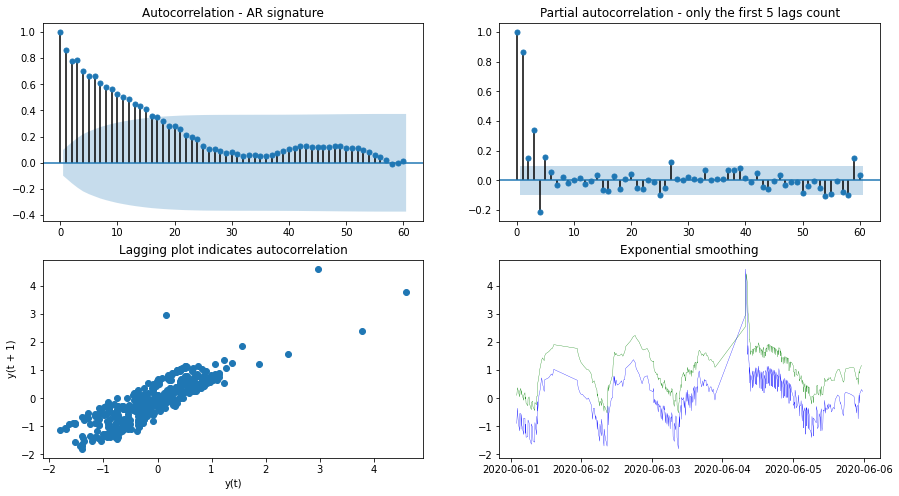

In [20]:
# Autocorrelation test
from statsmodels.tsa.stattools import adfuller,acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA

adf_result = adfuller(df_input['temperature'].dropna(),autolag='AIC')
print (adf_result)

if adf_result[1] < 0.05:
    print('p value < 5%, null hypothesis rejected, stationary')
else:
    print('p value >= 5%, null hypothesis cannot be rejected, non-stationary')

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 8))
autocorr = acf(df_input['temperature'], nlags=60)
plot_acf(df_input['temperature'].tolist(), lags=60, alpha=.05, ax=ax[0,0], title='Autocorrelation - AR signature');
plot_pacf(df_input['temperature'].tolist(), lags=60, alpha=.05, ax=ax[0,1], title='Partial autocorrelation - only the first 5 lags count');

print('Hmmm, our time series data appears to be significantly autocorrelated')

from pandas.plotting import lag_plot
lag_plot(df_input['temperature'], ax=ax[1,0]);
ax[1,0].set_title('Lagging plot indicates autocorrelation')

span = 3
y = df_input.reset_index().set_index('timestamp')
alpha = 2/(span+1)

y['SES3']=SimpleExpSmoothing(y['temperature']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
ax[1,1].plot(y.index, y['SES3']+1, color='green', lw=0.3)
ax[1,1].plot(y.index, y['temperature'], color='blue', lw=0.3)
ax[1,1].set_title('Exponential smoothing')


(-12.660528402650234, 1.307952795747647e-23, 3, 391, {'1%': -3.4471856790801514, '5%': -2.868960436182993, '10%': -2.5707229006220524}, 328.97860459747346)
p value < 5%, null hypothesis rejected, stationary
Hmmm, the difference time series data is no longer significantly autocorrelated


/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


(395, 2)


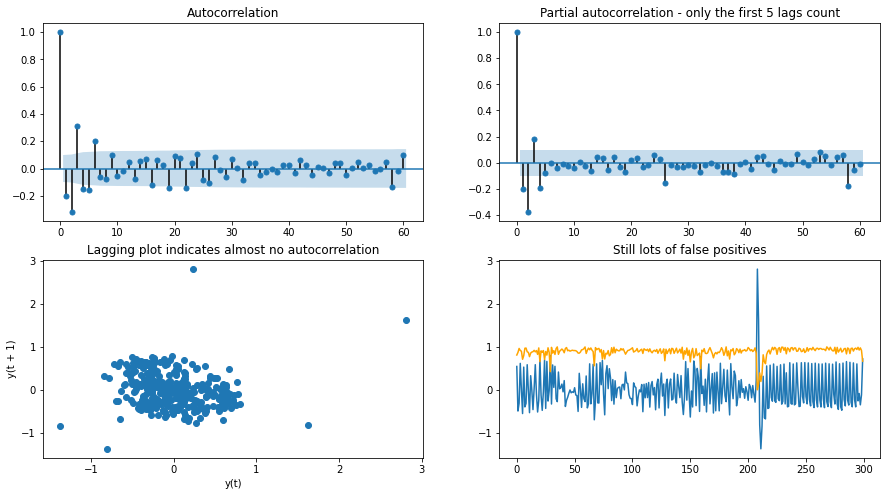

In [21]:
# differencing data first 
t = df_input['temperature'].diff().dropna()
df_input['tdiff'] = t

adf_result = adfuller(t,autolag='AIC')
print(adf_result)

if adf_result[1] < 0.05:
    print('p value < 5%, null hypothesis rejected, stationary')
else:
    print('p value >= 5%, null hypothesis cannot be rejected, non-stationary')

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 8))
autocorr = acf(t, nlags=60)
plot_acf(t.tolist(), lags=60, alpha=.05, ax=ax[0,0], title='Autocorrelation');
plot_pacf(t.tolist(), lags=60, alpha=.05, ax=ax[0,1], title='Partial autocorrelation - only the first 5 lags count');

print('Hmmm, the difference time series data is no longer significantly autocorrelated')

from pandas.plotting import lag_plot
lag_plot(t, ax=ax[1,0]);
ax[1,0].set_title('Lagging plot indicates almost no autocorrelation')


Xt = t.values.reshape(-1,1)
iforest = IForest(behaviour='new')
iforest.fit(Xt)
t_anom = iforest.predict_proba(Xt)
trunc = 300
ax[1,1].plot(range(trunc), t[0:trunc])
ax[1,1].plot(range(trunc), t_anom[0:trunc,0], color='orange')
ax[1,1].set_title('Still lots of false positives')
print (t_anom.shape)

/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
<ipython-input-81-eadbae3eb2f8>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=True, figsize=(20, 8))


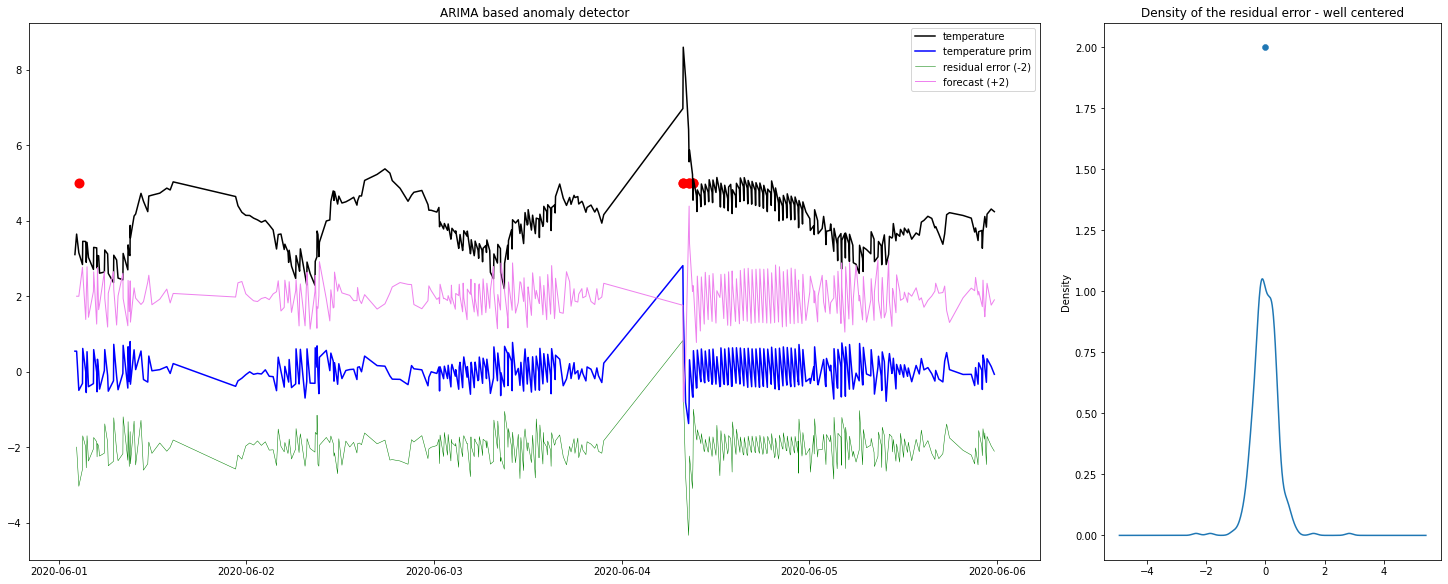

In [81]:
# Partial autocorrelation shows little influence of time steps beyond the first 5
df_inputm2['tdiff'] = df_inputm2['temperature'].diff().fillna(method='bfill')

ARIMA51model = ARIMA(df_inputm2['tdiff'], order=(5,1,0))
model_fit = ARIMA51model.fit(disp=0)
#print(model_fit.summary())

#residuals = pd.DataFrame(model_fit.resid)
df_inputm2['residuals'] = model_fit.resid

df_inputm2['res_anom'] = abs(model_fit.resid)
df_inputm2['res_anom'].values[df_inputm2['res_anom'] < 1] = np.nan
df_inputm2['res_anom'].values[df_inputm2['res_anom'] > 1] = 1
df_inputm2['arimapred'] = model_fit.predict()


#fig, ax = plt.figure(nrows=1, ncols=2, figsize=(20, 6))
fig = plt.figure(constrained_layout=True, figsize=(20, 8))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3,1], height_ratios=[1])

ax[0] = fig.add_subplot(spec[0, 0])
ax[0].plot(df_inputm2.index, df_inputm2['temperature']+4, color='black', label='temperature')
ax[0].plot(df_inputm2.index, df_inputm2['tdiff'], color='blue', label='temperature prim')
ax[0].plot(df_inputm2.index, df_inputm2['residuals']-2, lw=0.5, color='green', label='residual error (-2)')
ax[0].plot(df_inputm2.index, df_inputm2['arimapred']+2, lw=1, color='violet', label='forecast (+2)')
ax[0].scatter(df_inputm2.index, df_inputm2['res_anom']+4, lw=4, color='red')
ax[0].set_title('ARIMA based anomaly detector')
ax[0].legend()

ax[1] = fig.add_subplot(spec[0, 1])
ax[1] = df_inputm2['residuals'].plot(kind='kde', title='Density of the residual error - well centered')
ax[1].scatter(0,2,lw=0.5)


In [14]:
df_sample = df_input.reset_index().set_index('timestamp').resample("10T").mean()
df_sample.shape

(706, 6)

In [15]:
(df_input['temperature'] >= 0.4).cumsum().max() > 2

True

In [22]:
#df_input = df_input.drop(columns=['histogram','iforest','autoenc','kmeans'])
df_hist_  = df_input.groupby([pd.Grouper(freq='6H', level='timestamp'), pd.Grouper(level='deviceid')])
#df_hist_
#df_hist2 = df_hist_.apply(lambda x : print(np.histogram(x.temperature, bins=15, density=True)))
df_hist2 = df_hist_.agg({'temperature': lambda t: str(np.histogram(t, bins=15, density=True))})
df_hist2
#df_hist2['2020-01-30 07':'2020-01-30 08']
#df_hist2 = df_hist_.apply(lambda x: print(x)) #x.groupby([pd.cut(x.temperature, 15)]))
#df_hist2
#df_hist = df_hist2.apply(lambda x: x.apply(lambda y: print(y)))

,,temperature
timestamp,deviceid,
2020-06-01 00:00:00,CakebreadId_0036,"(array([1.60808431, 0.80404216, 0.80404216, 0...."
2020-06-01 06:00:00,CakebreadId_0036,"(array([0.9063195 , 0.3021065 , 0.3021065 , 0...."
2020-06-01 12:00:00,CakebreadId_0036,"(array([12.53655352, 0. , 0. ,..."
2020-06-01 18:00:00,CakebreadId_0036,"(array([7.52032668, 0. , 7.52032668, 0...."
2020-06-02 00:00:00,CakebreadId_0036,"(array([0.69807582, 0.69807582, 0. , 0...."
2020-06-02 06:00:00,CakebreadId_0036,"(array([0.50009827, 0.75014741, 0.50009827, 0...."
2020-06-02 12:00:00,CakebreadId_0036,"(array([2.83785967, 2.83785967, 1.41892983, 4...."
2020-06-02 18:00:00,CakebreadId_0036,"(array([3.04386209, 0. , 1.52193105, 1...."
2020-06-03 00:00:00,CakebreadId_0036,"(array([0.74211069, 0.37105534, 1.85527672, 0...."


#### Inspiration taken from 
[EuroScipy 2018 Detecting anomalies using statistical distances](https://www.euroscipy.org/2018/descriptions/Detecting%20anomalies%20using%20statistical%20distances.html)

if wasserstein and cramer-von mises are not sufficient turn to [python optimal transport](https://github.com/PythonOT/POT)

<ipython-input-42-985d79014329>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(2, 1, figsize=(15,10))


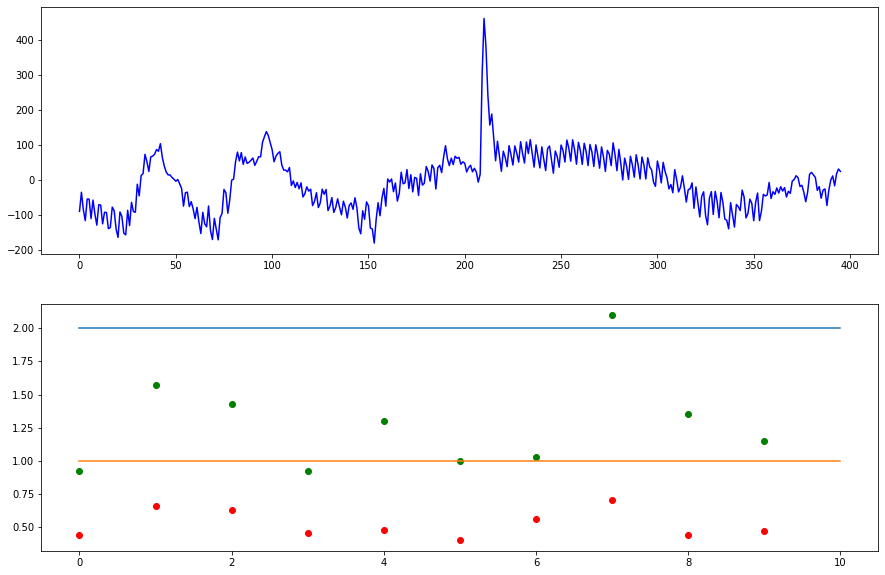

In [42]:


import statistics 

Barrier = 2
Barrier2 = 1
df_hist_ = df_input.reset_index().set_index('timestamp').\
    drop(columns=['histogram','iforest','autoenc','kmeans'])
df_hist = df_hist_.groupby([pd.Grouper(freq='12H'), pd.cut(df_hist_.temperature, 20)]).size().unstack()
#df_hist.head(1)

wasser = []
cramer = []
wasser_sum_ = []
cramer_sum_ = []

for index1, row1 in df_hist.iterrows():
    wasserI = []
    cramerI = []
    for index2, row2 in df_hist.iterrows():
        wasserI.append(wasserstein_distance(row1, row2))
        cramerI.append(energy_distance(row1, row2))
    wasser_sum_.append(statistics.median(wasserI))
    wasser.append(wasserI)
    cramer_sum_.append(statistics.median(cramerI))
    cramer.append(cramerI)

wasser_array = np.array(wasser)
cramer_array = np.array(cramer)

wasser_sum = np.array(wasser_sum_)
cramer_sum = np.array(cramer_sum_)

fig,ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].plot(range(df_input.index.size), df_input['temperature'] * 100, color='blue', zorder=2)
ax[1].scatter(range(wasser_sum.size), wasser_sum, color='green', label='wasserstein')
ax[1].scatter(range(cramer_sum.size), cramer_sum, color='red', label='cramer-von mises')
ax[1].plot((0,wasser_sum.size),(Barrier, Barrier), label='wasserstein anomaly threshold')
ax[1].plot((0,wasser_sum.size),(Barrier2, Barrier2), label='cramer-von mises anomaly threshold')

<ipython-input-43-24e9d3d88e26>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(YMAX,XMAX, figsize=(20,18))


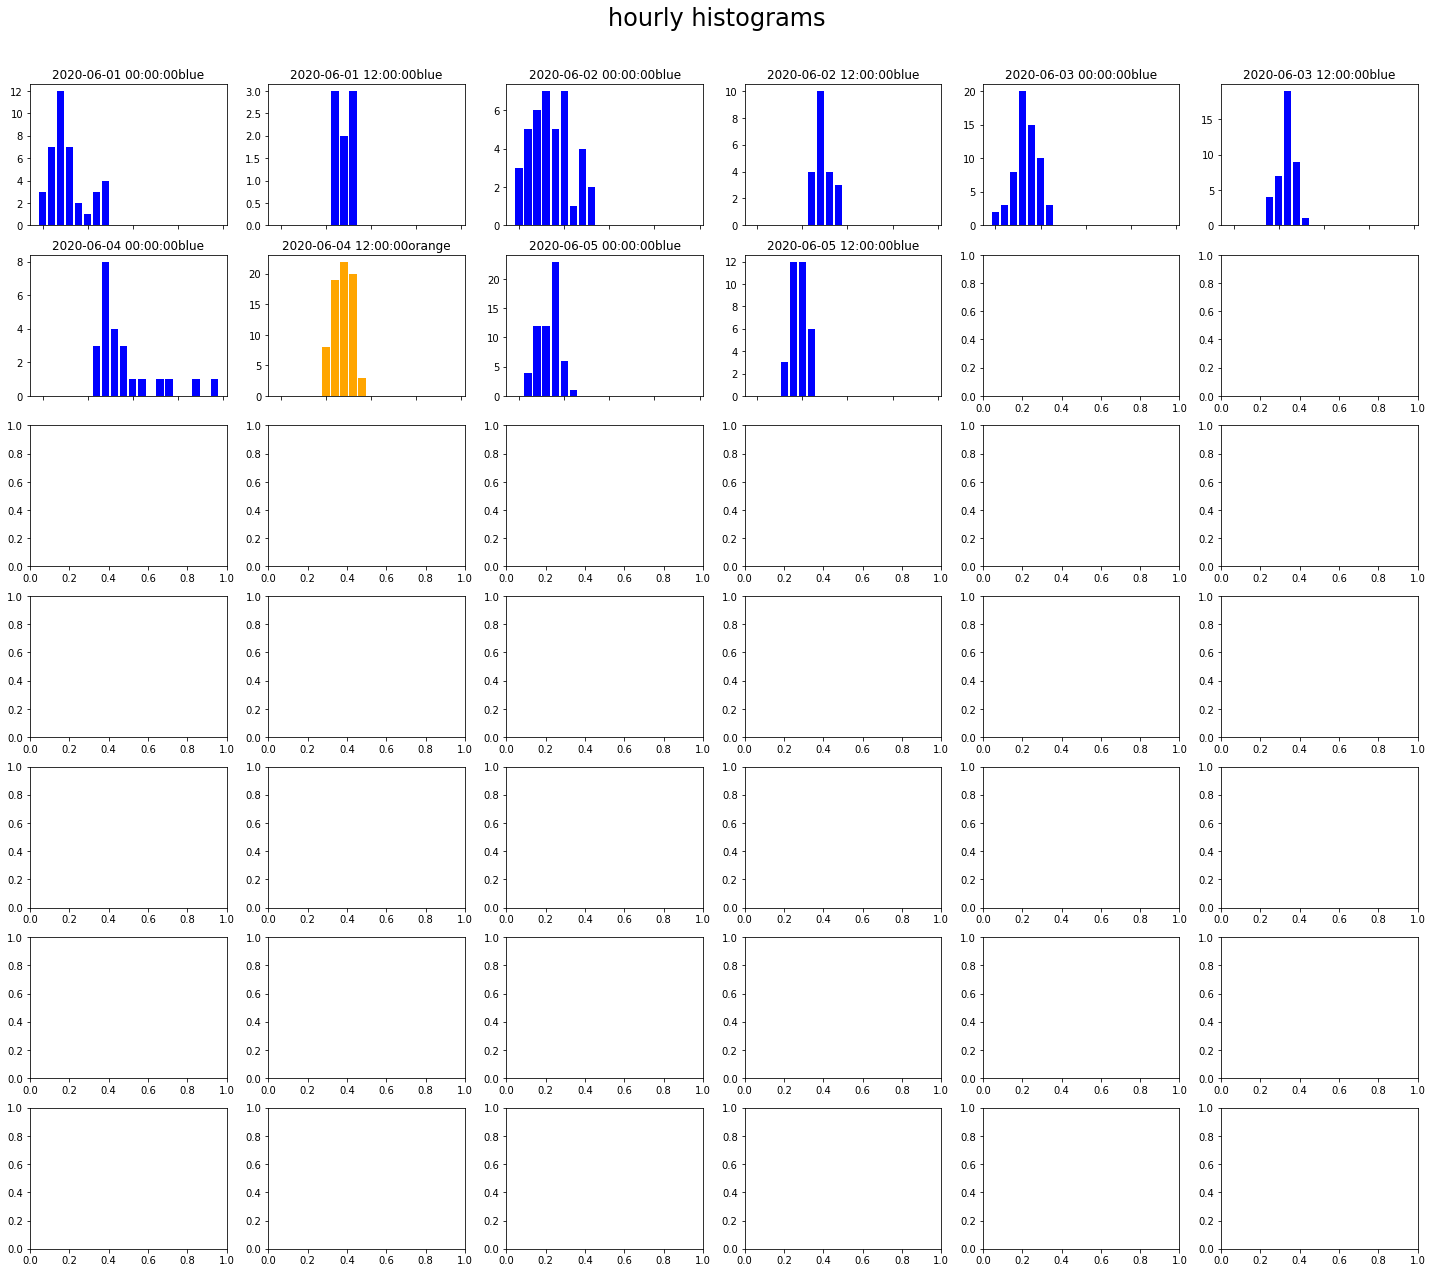

In [43]:
# show the histograms - histograms 33 to 35 are notably different
XMAX = 6
YMAX = 7
fig, ax = plt.subplots(YMAX,XMAX, figsize=(20,18))
fig.suptitle("hourly histograms", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.92)


i = 0
j = 0
for index, row in df_hist.iterrows():
    val = row.to_numpy()
    no = i * XMAX + j
    if val.size > 0:
        #print (index, no, wasser_sum[no], val)
        #if no >= 32 and no < 35:
        if cramer_sum[no] > Barrier2:
            my_color = 'red'   
        elif wasser_sum[no] > Barrier:
            my_color = 'orange'
        else:
            my_color = 'blue'
        #kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(val)
        #log_dens = kde.score_samples(np.arange(0, val.size))
        ax[i,j].bar(np.arange(0, val.size), val, color=my_color)
        ax[i,j].set_title(str(index) + my_color)
        ax[i,j].set_xticklabels([])
    j += 1
    if j == XMAX:
        j = 0
        i += 1
        if i == YMAX:
            break

<ipython-input-44-f83d670b5de0>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,figsize=(20,10))


Text(0.5, 1.0, 'Comparing cramer-von mises distances')

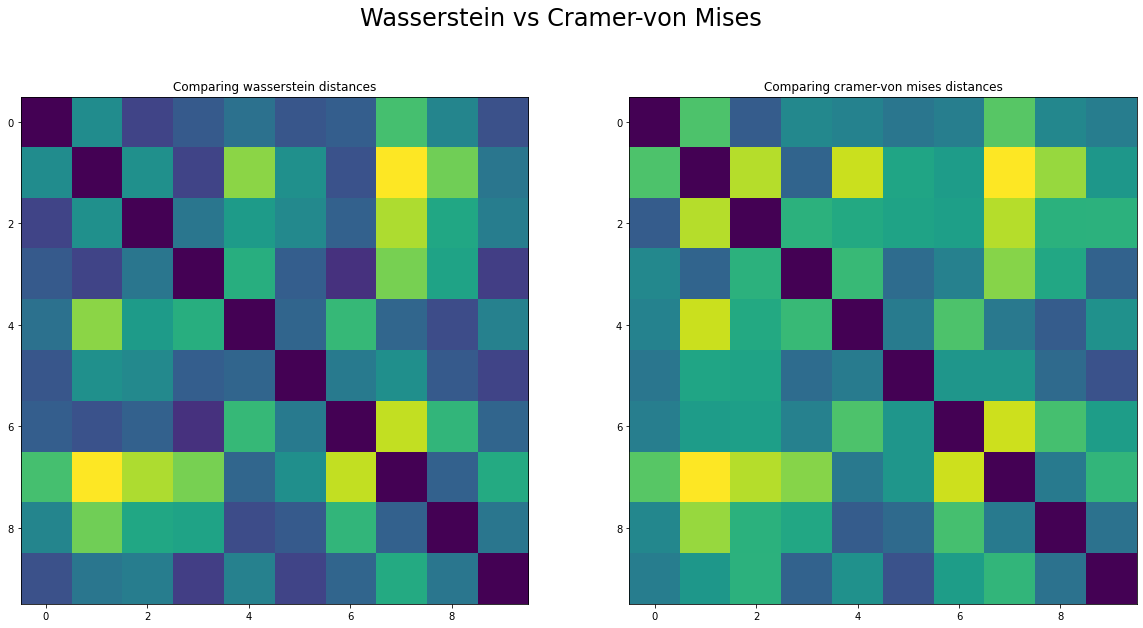

In [44]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Wasserstein vs Cramer-von Mises", fontsize=24)
im = ax[0].imshow(wasser_array)
ax[0].set_title('Comparing wasserstein distances')
im2 = ax[1].imshow(cramer_array)
ax[1].set_title('Comparing cramer-von mises distances')

In [40]:
%config InlineBackend.close_figures=False 
from ipywidgets import Layout, Button, ToggleButton, Box
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import Output


init_list = ['temperature','histogram', 'iforest', 'kmeans','autoenc']

items_layout = Layout( width='auto')

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    border='solid',
                    width='30%')

words = [ 'histogram', 'iforest', 'kmeans', 'autoenc']
items = [ToggleButton(description=word, layout=items_layout) for word in words]
box = Box(children=items, layout=box_layout)
ax = None

def plot_on_click(h,i, k, a):
    elements = ['temperature']
    if h:
        elements.append(words[0])
    if i:
        elements.append(words[1])
    if k:
        elements.append(words[2])
    if a:
        elements.append(words[3])
    # drop old figure first
    ax = plt.gca()
    if ax is not None:
        fig = ax.get_figure()
        plt.close(fig)
        
    df_subset = df_input[elements].head(200)
    ax = df_subset.plot(figsize=(10,4), title='Various Anomaly detectors   0 - okay, 1 - anomaly')
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)

w = interactive_output(plot_on_click, {'h': items[0], 'i': items[1], 'k': items[2], 'a': items[3]});
display(box, w)
#print (items[0])


Box(children=(ToggleButton(value=False, description='histogram', layout=Layout(width='auto')), ToggleButton(va…

Output()

Load unrolled data from CSV

In [6]:
credentials={"_id":"2d6dbddcd0ef52f54ab7e7a81f4face6","tenantId":"Monitor-Demo",             
             "db2":{"username":"bluadmin","password":"MjZkZTEwN2FjMWY1","databaseName":"BLUDB",                    
                    "port":50000,"httpsUrl":"https://dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:8443",
                    "host":"dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net"},
             "iotp":{"url":"https://vrvzh6.internetofthings.ibmcloud.com/api/v0002","orgId":"vrvzh6",
                     "host":"vrvzh6.messaging.internetofthings.ibmcloud.com","port":8883,
                     "asHost":"api-beta.connectedproducts.internetofthings.ibmcloud.com",
                     "apiKey":"a-vrvzh6-am4fwylysp","apiToken":"F+PF@HQhe_N*ecS4gb"},
             "messageHub":{"brokers":["kafka03-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka01-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka05-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka02-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka04-prod02.messagehub.services.us-south.bluemix.net:9093"],
                           "username":"S0Zzzp1zZsF4hotd","password":"S1wyAP2jy9R2cmqcZwSfoqL5gByWSqn9"},
             "objectStorage":{"region":"global","username":"5c9b5139a83d4f68bd2fe458a2117fac",
                              "password":"5b282a68b84d070bd8674da4771998c6cb0743a4a0288129"},
             "config":{"objectStorageEndpoint":"https://undefined",
                       "bos_logs_bucket":"analytics-logs-monitor-demo-9c6aaaf268a1",
                       "bos_runtime_bucket":"analytics-runtime-monitor-demo-395729cb6a06",
                       "mh_topic_analytics_alerts":"analytics-alerts-Monitor-Demo"}}
credentials['db2'] = {"username":"bluadmin","password":"NjYxYzIwODRkMjAx","databaseName":"BLUDB",
                      "port":50000,"httpsUrl":"https://dashdb-enterprise-yp-dal12-134.services.dal.bluemix.net:8443",
                      "host":"dashdb-enterprise-yp-dal12-134.services.dal.bluemix.net"}
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)


2020-04-15T14:17:10.685 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-04-15T14:17:10.686 INFO iotfunctions.db.__init__ Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:NjYxYzIwODRkMjAx@dashdb-enterprise-yp-dal12-134.services.dal.bluemix.net:50000/BLUDB;


In [7]:
df_input['T_copy'] = df_input['temperature']
df_fullcopy = df_input.copy()
df_input = df_input.head(2000)  # half of the data

In [8]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)

# !!!!!
# COPY feature to target - we're predicting future data points of the same column
# !!!!!
df_input['T_copy'] = df_input['temperature']

# need a second feature or bump into issue with Keras in predict
lstmii = LSTMRegressor(features=['temperature','histogram'], targets=['T_copy'], predictions=['T_pred'])
lstmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = lstmii._build_entity_type(columns = [Column('temperature',Float()), Column('histogram',Float()),
                                        Column('T_copy',Float())], **jobsettings)
lstmii._entity_type = et

# allow training and delete existing models
lstmii.auto_train = True
lstmii.delete_existing_models = True
lstmii.correlation_threshold = 0

# comment out to train
#lstmii.auto_train = False 
#lstmii.delete_existing_models = False
df_input = lstmii.execute(df=df_input)

2020-04-15T14:17:25.891 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-04-15T14:17:25.894 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-04-15T14:17:25.895 DEBUG iotfunctions.util.__init__ Starting trace
2020-04-15T14:17:25.895 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_LSTMRegressor_20200415121725
2020-04-15T14:17:25.896 DEBUG iotfunctions.util.__init__ auto_save None
2020-04-15T14:17:25.896 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-04-15T14:17:25.897 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-04-15T14:17:25.898 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_LSTMREGRESSOR
Functions:
Granularities:
No schedules metadata
2020-04-15T14:17:25.899 DEBUG mmfunc

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/markus/.local/lib/python3.7/site-packages/sqlalchemy/engine/reflection.py:919: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'TEST_ENTITY_FOR_LSTMREGRESSOR_AUTO_DIM'
  "columns for table '%s'" % (flavor, c, table_name)


2020-04-15T14:17:28.191 WARNING iotfunctions.pipeline.write Error while writing unmatched members to dimension. 'LocalEntityType' object has no attribute 'table'
2020-04-15T14:17:28.191 DEBUG iotfunctions.base.execute_preprocessing Completed preprocessing
2020-04-15T14:17:28.192 INFO iotfunctions.base._execute Prepare to train model {
 "name": "model.TEST_ENTITY_FOR_LSTMREGRESSOR.LSTMRegressor.T_copy.CakebreadId_0128",
 "target": "T_copy",
 "features": [
  "temperature",
  "histogram"
 ],
 "estimator_name": null,
 "eval_metric_name": "r2_score",
 "eval_metric_train": null,
 "eval_metric_test": null,
 "trained_date": null,
 "expiry_date": null
}
2020-04-15T14:17:28.192 INFO mmfunctions.telemanom.set_estimators LSTMRegressor start searching for best model
2020-04-15T14:17:28.193 DEBUG iotfunctions.base.make_estimators Selected estimators ['lstm_regressor']
2020-04-15T14:17:28.198 INFO mmfunctions.telemanom.fit_with_search_cv Fit directly
2020-04-15T14:17:28.200 INFO mmfunctions.telemanom

In [9]:
df_input

temperature  histogram  \
deviceid         timestamp                                               
CakebreadId_0128 2020-01-31 00:00:00.000000001         0.75   0.842633   
                 2020-01-31 00:00:00.000000002         0.50   0.906117   
                 2020-01-31 00:00:00.000000003         0.75   0.842633   
                 2020-01-31 00:00:00.000000004         0.00   0.919050   
                 2020-01-31 00:01:00.000000005        -0.50   0.626630   
...                                                     ...        ...   
                 2020-01-31 16:24:00.000000010         0.25   1.000000   
                 2020-01-31 16:25:00.000000000         0.00   0.919050   
                 2020-01-31 16:26:00.000000000         0.25   1.000000   
                 2020-01-31 16:27:00.000000001        -0.50   0.626630   
                 2020-01-31 16:27:00.000000002         0.00   0.919050   

                                                 iforest    kmeans  T_copy  \
deviceid         timestamp                                                   
CakebreadId_0128 2020-01-31 00:00:00.000000001  0.891105  1.000000    0.75   
                 2020-01-31 00:00:00.000000002  0.958521  1.000000    0.50   
                 2020-01-31 00:00:00.000000003  0.891105  1.000000    0.75   
                 2020-01-31 00:00:00.000000004  0.977031  1.000000    0.00   
                 2020-01-31 00:01:00.000000005  0.793552  0.742424   -0.50   
...                                                  ...       ...     ...   
                 2020-01-31 16:24:00.000000010  1.000000  1.000000    0.25   
                 2020-01-31 16:25:00.000000000  0.977031  1.000000    0.00   
                 2020-01-31 16:26:00.000000000  1.000000  1.000000    0.25   
                 2020-01-31 16:27:00.000000001  0.793552  0.742424   -0.50   
                 2020-01-31 16:27:00.000000002  0.977031  1.000000    0.00   

                                                  T_pred  
deviceid         timestamp                                
CakebreadId_0128 2020-01-31 00:00:00.000000001  0.000000  
                 2020-01-31 00:00:00.000000002  0.000000  
                 2020-01-31 00:00:00.000000003  0.000000  
                 2020-01-31 00:00:00.000000004  0.000000  
                 2020-01-31 00:01:00.000000005  0.000000  
...                                                  ...  
                 2020-01-31 16:24:00.000000010  0.218442  
                 2020-01-31 16:25:00.000000000  0.222453  
                 2020-01-31 16:26:00.000000000  0.226108  
                 2020-01-31 16:27:00.000000001  0.217677  
                 2020-01-31 16:27:00.000000002  0.215122  

[2000 rows x 6 columns]

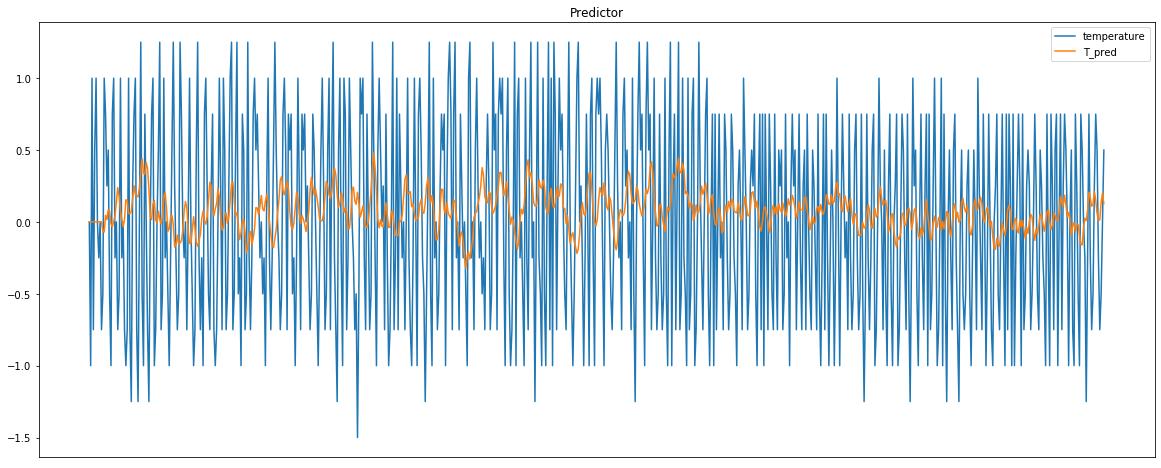

In [10]:
df_subset = df_input[['temperature','T_pred']].iloc[250:1000]
df_subset['T_pred'] *= 2
df_subset.plot(figsize=(20,8), title='Predictor')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

In [18]:
df_sec = df_fullcopy[['temperature','histogram']].copy() # .tail(3010)
pred = lstmii.estimator.predict(df_sec.values)

2020-04-15T14:22:18.240 INFO mmfunctions.telemanom.predict Predict: feature data shape: (3085, 2), target data shape: <nothing>
(3085, 2)
2020-04-15T14:22:18.251 DEBUG mmfunctions.telemanom.batch_predict predict: num_batches 25
2020-04-15T14:22:18.420 DEBUG mmfunctions.telemanom.batch_predict <class 'numpy.ndarray'>
2020-04-15T14:22:18.421 DEBUG mmfunctions.telemanom.batch_predict predict: batch 0 - (100, 10)
2020-04-15T14:22:18.590 DEBUG mmfunctions.telemanom.batch_predict <class 'numpy.ndarray'>
2020-04-15T14:22:18.590 DEBUG mmfunctions.telemanom.batch_predict predict: batch 1 - (100, 10)
2020-04-15T14:22:18.745 DEBUG mmfunctions.telemanom.batch_predict <class 'numpy.ndarray'>
2020-04-15T14:22:18.746 DEBUG mmfunctions.telemanom.batch_predict predict: batch 2 - (100, 10)
2020-04-15T14:22:18.894 DEBUG mmfunctions.telemanom.batch_predict <class 'numpy.ndarray'>
2020-04-15T14:22:18.895 DEBUG mmfunctions.telemanom.batch_predict predict: batch 3 - (100, 10)
2020-04-15T14:22:19.042 DEBUG mm

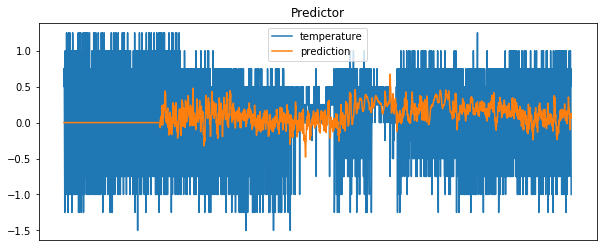

In [30]:
df_sec['prediction'] = pred
df_sec2 = df_sec[['temperature','prediction']].copy() #.iloc[600:1000]
df_sec2['prediction'] *= 2
df_sec2.plot(figsize=(10,4), title='Predictor')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

In [31]:
lstmii.estimator.errors.anom_scores

[]

#### Try out supervised methods

* Train a stacked LSTM
* Run gradient boosting


Text(0.5, 1.0, 'Vibration Forecast x-axis - predicted')

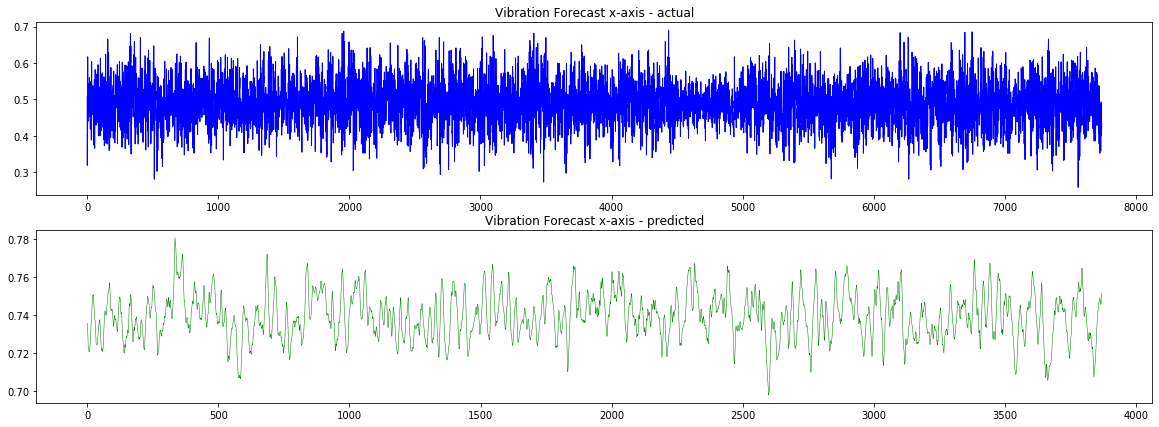

In [17]:
arr = np.ones(te.chan.y_test.size)
fig, ax = plt.subplots(2, 1, figsize=(20, 7))
#ax[0].plot(chan.y_train_hat[:8200] * 10, lw=0.2, color='green')  # to be done
ax[0].plot(te.chan.y_test[:,0], lw=1, color='blue', label='vibration')
ax[0].set_title('Vibration Forecast x-axis - actual')
#ax[1].plot(chan.y_hat[:chan.y_hat.shape[0] // 2] * 100 - 113.4, lw=0.5, color='green')
ax[1].plot(te.chan.y_hat[:te.chan.y_hat.shape[0] // 2] * 1.5 - 0, lw=0.5, color='green')
ax[1].set_title('Vibration Forecast x-axis - predicted')

[0.17138305 0.08545653 0.09594519 ... 0.02486044 0.0618619  0.00950603]


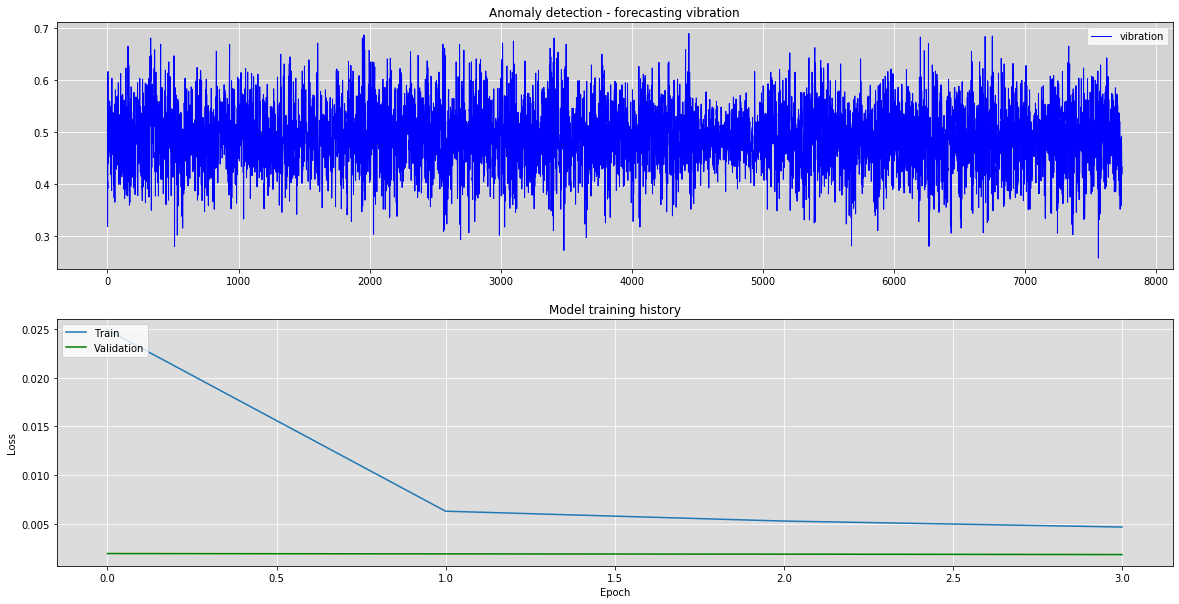

In [23]:
short = te.chan.y_hat.shape[0] // 2

npic = 1
fig, ax = plt.subplots(npic+1, 1, figsize=(20, (npic+1) * 5))
ax[npic-1].set_title('Anomaly detection - forecasting vibration')
ax[npic-1].plot(te.chan.y_test[:,0], lw=1, color='blue', label='vibration')

#ax.scatter(x_axis, temp_sal_high, lw=8, color='red')
for asc in te.errors.anom_scores:
    x_axis = np.arange(asc['start_idx'],asc['end_idx'],1)
    y_axis = np.zeros(asc['end_idx'] - asc['start_idx'])
    ax[npic-1].grid(True, color='white')
    ax[npic-1].set_facecolor('lightgrey')
    ax[npic-1].scatter(x_axis,y_axis+1.5, lw=5, color='red', zorder=10)
ax[npic-1].grid(True, color='white')
ax[npic-1].set_facecolor('lightgrey')
#ax[npic-1].plot(abs(chan.y_hat - chan.y_test[:,0]) + 3, lw=3, color='green', label='deviation')
#ax[npic-1].plot((chan.y_hat[:short] - 0.4)*6, lw=2, color='darkgreen',label='prediction',zorder=5)
ax[npic-1].legend()
    
ax[npic].set_xlabel('Epoch')
ax[npic].set_ylabel('Loss')
ax[npic].set_title('Model training history')
ax[npic].plot(te.model.history.history['loss'])
ax[npic].plot(te.model.history.history['val_loss'],color='green')
ax[npic].grid(True, color='white')
ax[npic].set_facecolor('gainsboro')
ax[npic].legend(['Train', 'Validation'], loc='upper left')


lstmscore = np.abs(abs(te.chan.y_hat[:short] - te.chan.y_test[:short,1]))
print (lstmscore)

#### LSTM in pipeline



In [12]:
# part of mmfunctions
import telemanom
from telemanom.helpers import Config
from telemanom.errors import Errors
import telemanom.helpers as helpers
from telemanom.channel import Channel
from telemanom.modeling import Model

conf = Config("./telemanom/config.yaml")

#list_attr=['Vx','Vy','Vz']
list_attr=['Vx','speed'] # minimal

#list_attr=['vibrations','accel_power_0']
conf.dictionary['l_s'] = 250
conf.dictionary['epochs'] = 80
conf.dictionary['dropout'] = 0.2
conf.l_s = 250
# conf.epochs = 80
conf.dropout = 0.2
conf.lstm_batch_size=80

Using TensorFlow backend.


In [13]:

tel_input = df_input[list_attr].values   # n-dim numpy array - predict first value
tel_input = abs(tel_input - tel_input.mean())
tel_inputb = df_inputb[list_attr].values
tel_inputb = abs(tel_inputb - tel_inputb.mean())
np.save("telemanom/data/train/Armstarknew.npy", tel_input)
np.save("telemanom/data/test/Armstarknew.npy", tel_inputb)
tel_input.shape

(129300, 2)

In [14]:
# Load data from 
device="Armstarknew"
chan = Channel(conf, device)
helpers.make_dirs(conf.use_id, conf, "./telemanom")
print(chan)
conf


Channel:Channel


In [15]:
print(chan.ffttrain)

None


In [17]:
#chan.delete_data("./telemanom")
chan.config.FFT = False
#chan.load_data("./telemanom")
# instead of loading from file simply set and shape
chan.train = tel_input
chan.test = tel_inputb
chan.shape_data(chan.train)
chan.shape_data(chan.test, train=False)

# chan.train
#dfA = pd.DataFrame(chan.ffttrain)
dfA = pd.DataFrame(chan.train)
dfA.head(2)

2020-03-31T18:50:46.148 INFO telemanom.shape_data FFT channel: False
(129300, 2)
2020-03-31T18:50:46.830 INFO telemanom.shape_data FFT channel: False
(129195, 2)


,0,1
0,0.541443,0.538457
1,0.540543,0.538457


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


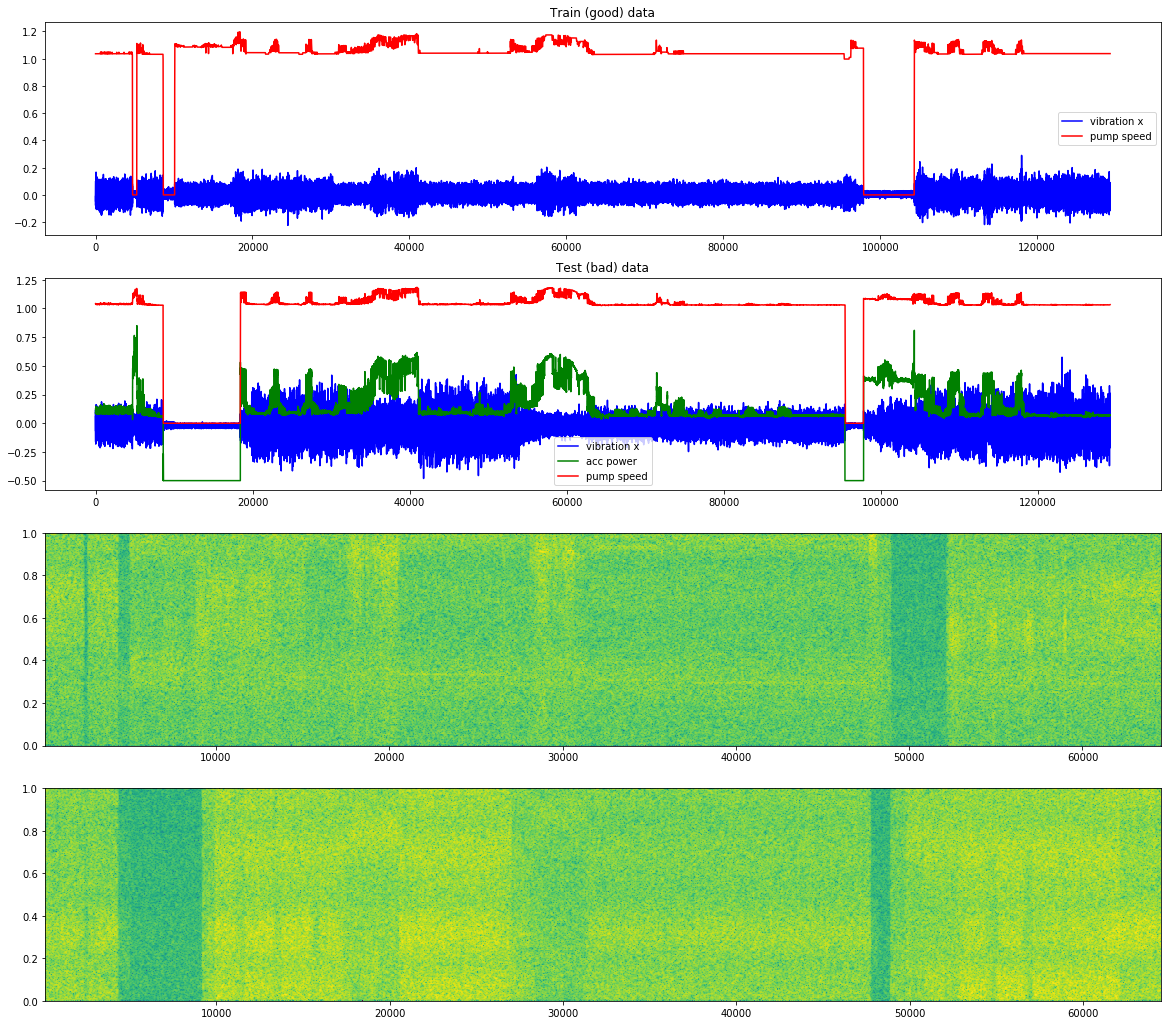

In [18]:
# chan.train

vibxg = df_input['Vx'].values
vibxb = df_inputb['Vx'].values
accpg = df_input['Ap'].values
accpb = df_inputb['Ap'].values
accsg = df_input['speed'].values
accsb = df_inputb['speed'].values

fig, ax = plt.subplots(4, 1, figsize=(20, 18))
cnt = 0 
ax[cnt].plot(vibxg, color='blue', label='vibration x')
#ax[cnt].plot(accpg/4-0.5, color='green', label='acc power')
ax[cnt].plot(accsg, color='red', label='pump speed')
ax[cnt].legend()
ax[cnt].set_title('Train (good) data')

cnt += 1
ax[cnt].plot(vibxb, color='blue', label='vibration x')
ax[cnt].plot(accpb/4-0.5, color='green', label='acc power')
ax[cnt].plot(accsb, color='red', label='pump speed')
ax[cnt].set_title('Test (bad) data')
ax[cnt].legend()

noverlap = 8
NFFT = 512
cnt += 1
PxxG, freqsG, binsG, imG = ax[cnt].specgram(chan.train[:,0],
                                          Fs=2, NFFT=NFFT, 
                                          detrend='mean', noverlap=NFFT-noverlap, mode='psd')
cnt += 1
PxxB, freqsB, binsB, imB = ax[cnt].specgram(chan.test[:,0],
                                          Fs=2, NFFT=NFFT, 
                                          detrend='mean', noverlap=NFFT-noverlap, mode='psd')

plt.show()

In [19]:
# producing overlapping windows of length 260 for lookback (250) and prediction (10)
chan.shape_data(chan.train, train=True)
chan.shape_data(chan.test, train=False)

2020-03-31T18:51:43.665 INFO telemanom.shape_data FFT channel: False
(129300, 2)
2020-03-31T18:51:44.418 INFO telemanom.shape_data FFT channel: False
(129195, 2)


In [20]:
# init the Keras double stacked LSTM model
model = Model(conf, conf.use_id, chan, "./telemanom", False)

In [21]:
# drink a coffee - training takes roughly 30 minutes
model.train_new(chan)

Train on 103232 samples, validate on 25808 samples
Epoch 1/35
103232/103232 [==============================] - 396s 4ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 2/35
103232/103232 [==============================] - 398s 4ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/35
103232/103232 [==============================] - 402s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/35
103232/103232 [==============================] - 384s 4ms/step - loss: 0.0015 - val_loss: 0.0014


#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>

In [128]:
# predicting takes roughly 12 secs
model.batch_predict(chan, Path="./telemanom")

In [129]:
# smooth the prediction error and apply exponential weights to it
errors = Errors(chan, conf, conf.use_id, "./telemanom")

#  for each overlapping window establish a threshold so that removing error points above it 
# maximizes the reduction of mean and standard deviation. Sort of an adaptive z-score 
errors.process_batches(chan)

2020-03-16T21:15:19.953 INFO telemanom.__init__ normalized prediction error: 0.06


In [130]:
print (errors.E_seq, " \n ", errors.anom_scores)

[(8650, 9049), (19850, 20249), (41150, 41649), (95450, 95849), (99650, 99749), (101750, 101849)]  
  [{'start_idx': 8400, 'end_idx': 8499, 'score': 1.8819864334481131}, {'start_idx': 8500, 'end_idx': 8599, 'score': 2.4118219828938288}, {'start_idx': 8600, 'end_idx': 8699, 'score': 2.8350391123177623}, {'start_idx': 8700, 'end_idx': 8799, 'score': 3.129021297489508}, {'start_idx': 19600, 'end_idx': 19699, 'score': 6.1292143015223886}, {'start_idx': 19700, 'end_idx': 19799, 'score': 6.164415706483887}, {'start_idx': 19800, 'end_idx': 19899, 'score': 6.160624087183549}, {'start_idx': 19900, 'end_idx': 19999, 'score': 6.180099691069643}, {'start_idx': 40900, 'end_idx': 40999, 'score': 1.549790375651836}, {'start_idx': 41000, 'end_idx': 41099, 'score': 1.9420454097273365}, {'start_idx': 41100, 'end_idx': 41199, 'score': 2.3567182735433736}, {'start_idx': 41200, 'end_idx': 41299, 'score': 2.2956307295217417}, {'start_idx': 41300, 'end_idx': 41399, 'score': 2.3550736364688305}, {'start_idx': 

In [131]:
model.save("./telemanom")

In [132]:
# How good are we doing ?

model.model.evaluate(chan.X_test, chan.y_test)

128935/128935 [==============================] - 163s 1ms/step


0.00590012299512361

In [133]:
model.model.metrics_names

['loss']

In [134]:
model.batch_predict(chan, Path="./telemanom", Train=False)


We're seeing a prediction lag, maybe due to the nature of the timeseries data- see also this [article](https://stats.stackexchange.com/questions/280939/lag-between-predicted-output-and-real-output-in-time-series-prediction-directio).

From this article:

If the data generating process is a random walk, 

$x_t = x_{t-1} + \varepsilon_t$

with $\varepsilon_t \sim i.i.d.(0,\sigma^2)$ the optimal* one-step-ahead prediction is 

\begin{equation}
\hat x_{t+1|t}:=\mathbb{E}(x_{t+1}|x_{t},x_{t-1},\dots)=x_{t}
\end{equation}

which happens to be the realization $x_{t+1}$ lagged by one ($x_{t}$ is $x_{t+1}$ lagged by 1). Given the data generating process, this apparently lagging prediction is the best we can get*. Then there is no way we can "fix" the "problem of lagging predictions; the problem is built-in due to the nature of the data generating process.


Text(0.5, 1.0, 'Vibration Forecast x-axis - predicted')

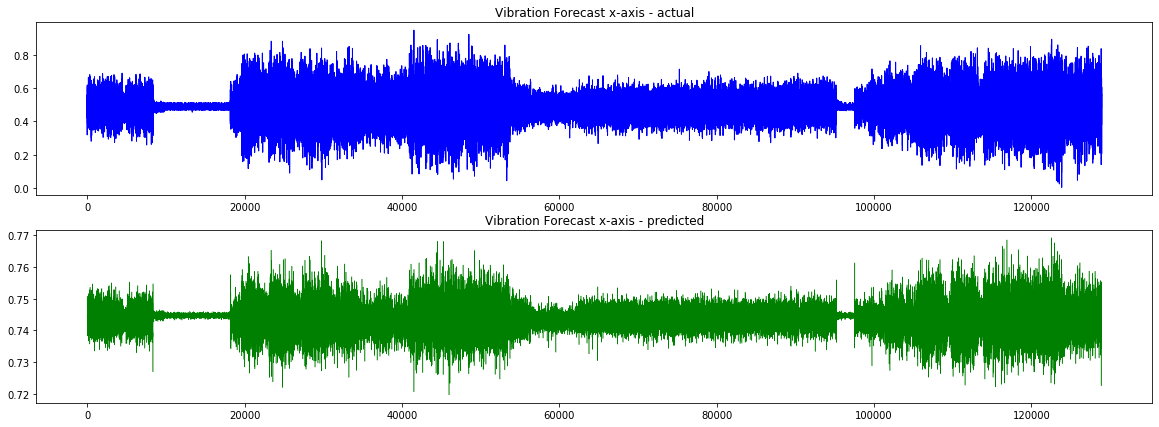

In [145]:
arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(2, 1, figsize=(20, 7))
#ax[0].plot(chan.y_train_hat[:8200] * 10, lw=0.2, color='green')  # to be done
ax[0].plot(chan.y_test[:,0], lw=1, color='blue', label='vibration')
ax[0].set_title('Vibration Forecast x-axis - actual')
#ax[1].plot(chan.y_hat[:chan.y_hat.shape[0] // 2] * 100 - 113.4, lw=0.5, color='green')
ax[1].plot(chan.y_hat[:chan.y_hat.shape[0] // 2] * 1.5 - 0, lw=0.5, color='green')
ax[1].set_title('Vibration Forecast x-axis - predicted')

[0.1774626  0.09110776 0.10607143 ... 0.10401793 0.05571466 0.07051344]


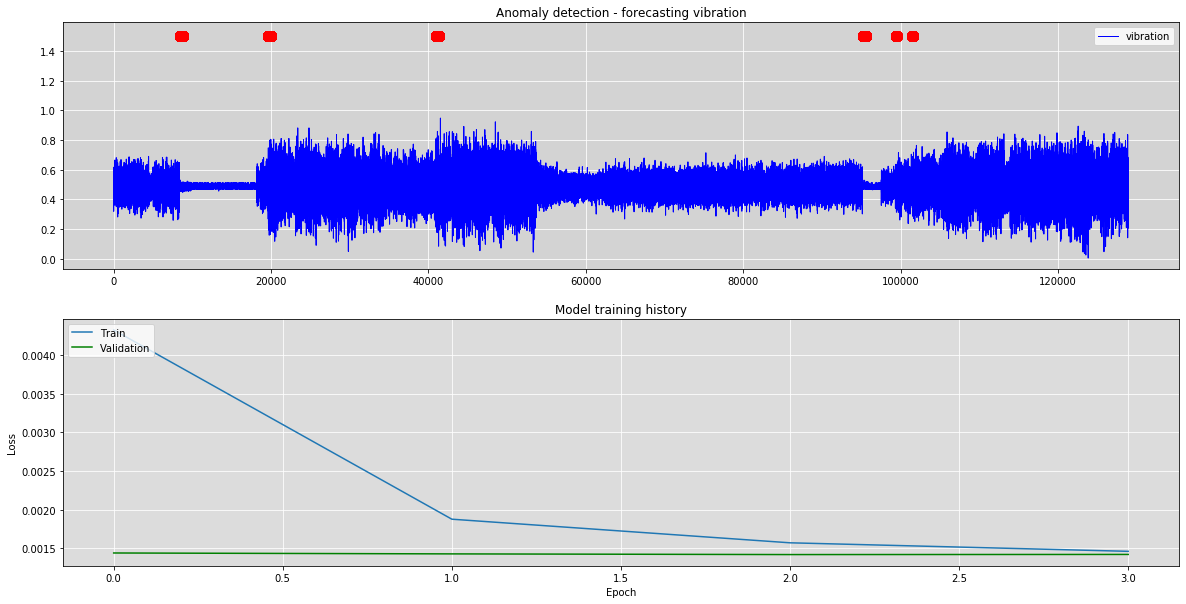

In [136]:
short = chan.y_hat.shape[0] // 2

npic = 1
fig, ax = plt.subplots(npic+1, 1, figsize=(20, (npic+1) * 5))
ax[npic-1].set_title('Anomaly detection - forecasting vibration')
ax[npic-1].plot(chan.y_test[:,0], lw=1, color='blue', label='vibration')

#ax.scatter(x_axis, temp_sal_high, lw=8, color='red')
for asc in errors.anom_scores:
    x_axis = np.arange(asc['start_idx'],asc['end_idx'],1)
    y_axis = np.zeros(asc['end_idx'] - asc['start_idx'])
    ax[npic-1].grid(True, color='white')
    ax[npic-1].set_facecolor('lightgrey')
    ax[npic-1].scatter(x_axis,y_axis+1.5, lw=5, color='red', zorder=10)
ax[npic-1].grid(True, color='white')
ax[npic-1].set_facecolor('lightgrey')
#ax[npic-1].plot(abs(chan.y_hat - chan.y_test[:,0]) + 3, lw=3, color='green', label='deviation')
#ax[npic-1].plot((chan.y_hat[:short] - 0.4)*6, lw=2, color='darkgreen',label='prediction',zorder=5)
ax[npic-1].legend()
    
ax[npic].set_xlabel('Epoch')
ax[npic].set_ylabel('Loss')
ax[npic].set_title('Model training history')
ax[npic].plot(model.history.history['loss'])
ax[npic].plot(model.history.history['val_loss'],color='green')
ax[npic].grid(True, color='white')
ax[npic].set_facecolor('gainsboro')
ax[npic].legend(['Train', 'Validation'], loc='upper left')


lstmscore = np.abs(abs(chan.y_hat[:short] - chan.y_test[:,1]))
print (lstmscore)
#ax[1].plot(chan.test[:,0], lw=1, color='blue')
#ax[1].set_xlabel('Date')
#ax[1].set_ylabel('Compare with raw training data')


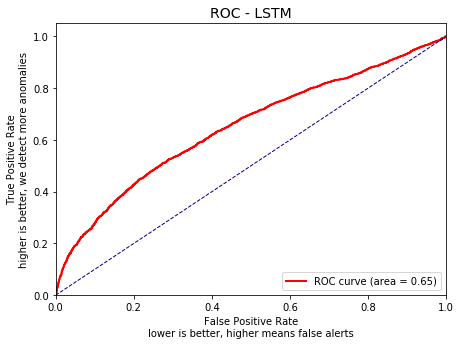

In [37]:
# ROC curve LSTM

fprFg, tprFg, _ = roc_curve(yyy_test[0:yyy_test.size - conf.l_s - conf.n_predictions], lstmscore)
roc_aucFg = auc(fprFg, tprFg)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(fprFg, tprFg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_aucFg)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\nlower is better, higher means false alerts')
plt.ylabel('True Positive Rate\nhigher is better, we detect more anomalies')
plt.title('ROC - LSTM', fontsize=14)
plt.legend(loc="lower right")
plt.show()


In [47]:
# Now run gradient boosting - using lightGBM

X_train = df_input[['accel_power_0','accel_power_1','accel_power_2',
                    'accel_power_3','accel_power_4']].to_numpy()
y_train = df_input['vibrations'].to_numpy()

In [48]:
import lightgbm
gbr = lightgbm.LGBMRegressor(n_estimators=4000, learning_rate=0.000001, num_leaves=40,
                           max_depth=20, random_state=42, loss='huber').fit(X_train, y_train)


In [49]:

pred_good = gbr.predict(X_train)
rmse = metrics.mean_squared_error(y_train, pred_good)
gbscoreg = np.abs(pred_good - y_train)
print (rmse)

0.001106535670881264


In [50]:
X_bad = df_inputb[['accel_power_0','accel_power_1','accel_power_2',
                   'accel_power_3','accel_power_4']].to_numpy()
y_bad = df_inputb['vibrations'].to_numpy()
pred_bad = gbr.predict(X_bad) 
rmseb = metrics.mean_squared_error(y_bad, pred_bad)
gbscore = np.abs(pred_bad - y_bad)
print (rmseb)

0.009797515412096496


Text(0.5, 1.0, 'Good Case - no anomalous deviation from prediction')

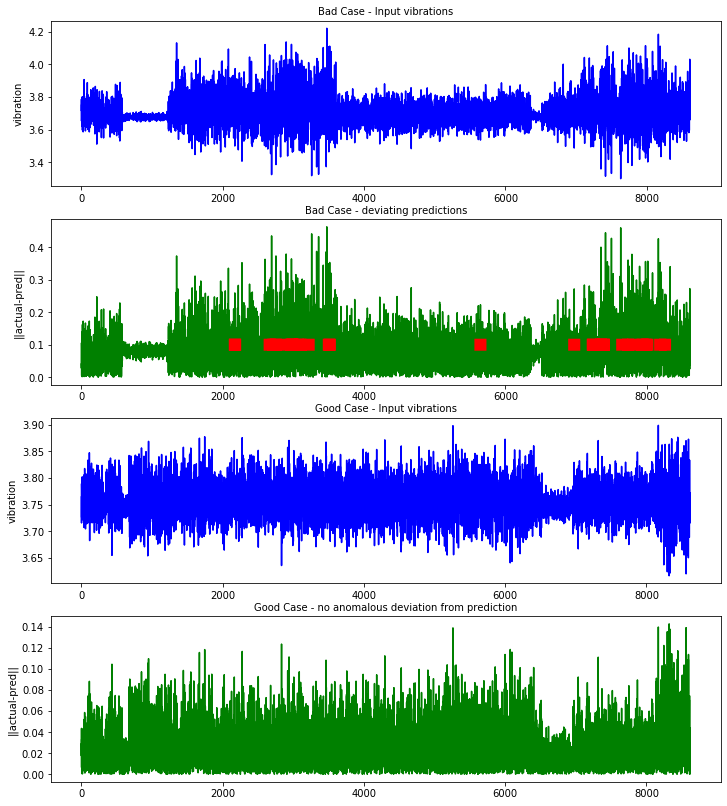

In [51]:
separator = 0.2
anomalygb = gbscore.copy() #(gbscore > separator) # * (separator + 0.1)
anomalygb[anomalygb <= separator] = 0
anomalygb[anomalygb > separator] = separator/2
anomalygb[anomalygb == 0] = np.nan
anomalygg = gbscoreg.copy()
anomalygg[anomalygg <= separator] = 0
anomalygg[anomalygg > separator] = separator/2
anomalygg[anomalygg == 0] = np.nan

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,14)) 
ax1.plot(y_bad, color='blue')
ax1.set_title('Bad Case - Input vibrations', fontsize=10)
ax1.set_ylabel('vibration')
ax2.plot(gbscore, color='green')
ax2.plot(anomalygb, color='red', lw=12, zorder=10)
ax2.set_ylabel('||actual-pred||')
ax2.set_title('Bad Case - deviating predictions', fontsize=10)
ax3.plot(y_train, color='blue')
ax3.set_ylabel('vibration')
ax3.set_title('Good Case - Input vibrations', fontsize=10)
ax4.plot(gbscoreg, color='green')
ax4.plot(anomalygg, color='red', lw=12, zorder=10)
ax4.set_ylabel('||actual-pred||')
ax4.set_title('Good Case - no anomalous deviation from prediction', fontsize=10)



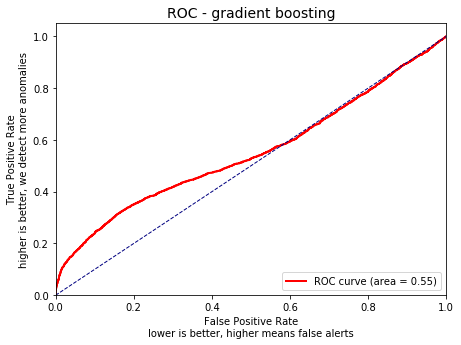

In [52]:
# ROC curve Gradient Boosting

fprFg, tprFg, _ = roc_curve(yyy_test, gbscore)
roc_aucFg = auc(fprFg, tprFg)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(fprFg, tprFg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_aucFg)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\nlower is better, higher means false alerts')
plt.ylabel('True Positive Rate\nhigher is better, we detect more anomalies')
plt.title('ROC - gradient boosting', fontsize=14)
plt.legend(loc="lower right")
plt.show()


#### Results

Gradient boosting appeared to do much better until Shradda fixed the ROC curve plot.

Now I understand (and accept) why I had to explicitly disable the r2_score check in the pipeline's GBMRegressor to enforce saving the model to Cloud Object Store.

Training time is much shorter compared to the NASA model, but there is a price


In [53]:
from sklearn.metrics import r2_score

'''
Coefficent of determinatoin: the proportion of the variance in the dependent variable 
that is predictable from the independent variable(s). It provides a measure of how well 
observed outcomes are replicated by the model, based on the proportion of total variation 
of outcomes explained by the model
Best posible score = 1.0
Values of r2 outside 0-1: model fits data worse than a horizontal hyperplane
'''

print('R_sq/Test Variance score:' + str(r2_score(y_bad, pred_bad)))

R_sq/Test Variance score:-0.25058676111247435


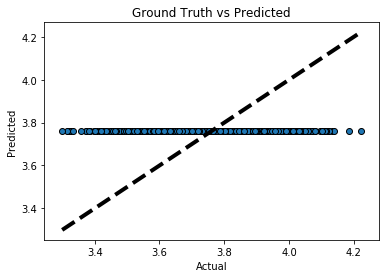

In [54]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_bad, pred_bad, edgecolors=(0, 0, 0))
ax.plot([y_bad.min(), y_bad.max()], [y_bad.min(), y_bad.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()